In [26]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

# Решение уравнения методом Рунге-Кутта, в предположении известных начальных условий

Исходный вид уравнения:
$$\frac{d^2 x}{dt^2} + \alpha \frac{\frac{dx}{dt}}{\sqrt{(1+(\frac{dx}{dt})^2)}} - x - x^3 = \cos{t}$$
Обозначим $y_1 = x, y_2 = \frac{dx}{dt}$

Перепишем уравнение в систему двух:
$$\dot{y_1} = y_2$$
$$\dot{y_2} = y_1 + y_1^3 - \alpha \frac{y_2}{\sqrt{1+y_2^2}} + \cos{t}$$

Обозначим $\overline{y} = (y_1, y_2)$, и $ \dot{\overline{y}} = f(t, \overline{y})$

In [27]:
def f(t, y, alpha = 1):  #or a = 2
    y1, y2 = y
    yy1 = y2
    yy2 = y1 + y1**3 - alpha*y2/(1+y2**2)**(1/2) + np.cos(t)
    return np.array([yy1, yy2])

Решать будем Рунге-Кутта 4ого порядка:
$$\textbf{k}_1 = \textbf{f} \left( t_n, \textbf{y}_n \right), $$
$$\textbf{k}_2 = \textbf{f} \left( t_n + {h \over 2}, \textbf{y}_n + {h \over 2} \textbf{k}_1 \right), $$
$$\textbf{k}_3 = \textbf{f} \left( t_n + {h \over 2}, \textbf{y}_n + {h \over 2} \textbf{k}_2 \right), $$
$$\textbf{k}_4 = \textbf{f} \left( t_n + h, \textbf{y}_n + h\ \textbf{k}_3 \right). $$
$$\textbf{y}_{n+1} = \varphi(t_n,  \textbf{y}_n) = \textbf{y}_n + {h \over 6}(\textbf{k}_1 + 2\textbf{k}_2 + 2\textbf{k}_3 + \textbf{k}_4)$$

Точность метода порядка $o(h^4)$. Для простаты по умолчанию считаем $h=0.1$

In [28]:
def phi(t, y, h=0.001, alpha = 1):
    #print(t, y)
    k1 = f(t, y, alpha=alpha)
    k2 = f(t + h/2, y + h/2*k1, alpha=alpha)
    k3 = f(t + h/2, y + h/2*k2, alpha=alpha)
    k4 = f(t + h, y + h*k3, alpha=alpha)
    
    return y + h/6*(k1 + 2*k2 + 2*k3 + k4)

Решать будем на $t \in [-\pi, \pi]$, i.e. $t_0 = -\pi$. Допустим знаем $\overline{y}(-\pi) = (x, \dot{x}) = (y_{10}, y_{20})$, тогда итеративно $\textbf{y}_{n+1} = \varphi(t_n,  \textbf{y}_n)$. После $t_n = 3.1$ считаем $h = \pi - 3.1$. Значения $\overline{y}$ на значениях сетки будем хранить в $ans\_grid$. 

In [29]:
#if nan stops
def solve(y0, alpha=1):
    h=2*np.pi/1000
    ans_grid = []
    ans_grid.append(y0)
    
    left = 0
    right = 2*np.pi
    t_grid = [0]
    t = left;

    while(True):
        ans_grid.append(phi(t, ans_grid[-1], h, alpha=alpha))
        t += h
        t_grid.append(t)
        
        
        if (t>right):
            break
        #if (right - t < h):
        #    ans_grid.append(phi(t, ans_grid[-1], right - t, alpha=alpha))
        #    t_grid.append(right)
        #    break
            
        if np.isnan(ans_grid[-1][0]):
            break
    return (t_grid, ans_grid)

# Оптимизация начального значения
Для поиска периодического решения можно сформулировать задачу как задачу оптимизации разницы между $|\overline{y}(0) - \overline{y}(2 \pi)|$, введем соответствующий функционал потерь:

In [30]:
def error(y0, plot = 0, alpha=1, mode='1D'):
    t_grid, ans_grid = solve(y0, alpha=alpha)
    if plot:
        ans_grid = np.array(ans_grid)
        plt.plot(t_grid, ans_grid)
    #print(ans_grid[-1])
    if mode == '1D':
        return np.linalg.norm(ans_grid[-1] - y0)**2
    elif mode == '2D':
        return ans_grid[-1] - y0

Пример работы алгоритма, случайные начальные значения и подобранные так чтобы решение сходилось на $[0, 2\pi]$:

0.22638488917265964

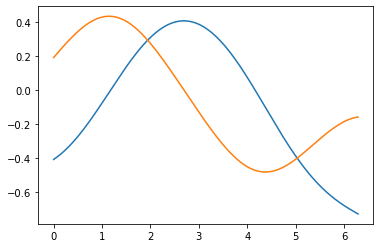

In [31]:
bp = [-0.40987573,  0.19126111]

error(bp, plot=1)
#решение улетает в сингулярность(в небытие)

1.5529982637621713

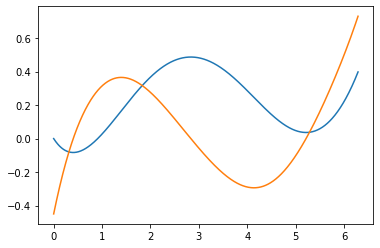

In [32]:
bp = [ 0, -0.45]

error(bp, plot=1, alpha=1)

Для примера, методом Нелдера — Мида, устойчивого к сингулярностям, "угадаем" начальные параметры, для которых получается периодическое решение:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 88
         Function evaluations: 172
[-0.39149294  0.16678684]


4.437761395703871e-17

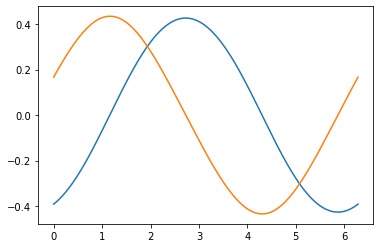

In [12]:
from scipy.optimize import minimize 

sol = minimize(error, bp, method='nelder-mead',
               options={'xatol': 1e-8, 'disp': True})

print(sol.x)
error(sol.x, plot=1)

## Метод стрельбы, инициализация

Простреляем квадрат $[-1, 1]^2$, для поиска начальных значений при которых решение хотя бы существует на $[0, 2\pi]$

In [67]:
#import warnings
#warnings.filterwarnings("ignore")

In [65]:
def Shooting(iters = 2, d_steps=3, alpha=1):
    anss = []
    for x in tqdm(np.arange(-1, 1.1, 0.1)):
        a0 = []
        for y in np.arange(-1, 1.1, 0.1):
            a0.append(error([x,y], alpha=alpha))
        anss.append(a0)
        
    anss = np.array(anss)
    nonnanvals = []
    errors = []
    for i, x in enumerate(anss.reshape(1,-1)[0]):
        if not np.isnan(x):
            nonnanvals.append(np.array([i//21, i%21])*0.1 - [1, 1])
            errors.append(x)
    
    
    for it in tqdm(range(1, iters+1)): 
        nonvals_new = []
        errors = []
        for p in tqdm(nonnanvals):
            x_new, y_new = p
            error_new = error(p, alpha=alpha)
            for x in np.arange(p[0]-d_steps*10**(-it-1), p[0]+d_steps*10**(-it-1), 10**(-it-1)):
                for y in np.arange(p[1]-d_steps*10**(-it-1), p[1]+d_steps*10**(-it-1), 10**(-it-1)):
                    er = error([x, y])
                    if er < error_new:
                        error_new, x_new, y_new = er, x, y
            nonvals_new.append([x_new, y_new])
            errors.append(error_new)
        nonnanvals = nonvals_new
        
    return np.array(nonnanvals), errors


In [37]:
nonnanvals1, errors1 = Shooting(iters=0)
print(nonnanvals1)

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

[[-0.7  0.7]
 [-0.6  0.5]
 [-0.4  0.2]
 [-0.3  0. ]
 [-0.2 -0.1]
 [-0.1 -0.3]
 [ 0.  -0.5]
 [ 0.1 -0.6]
 [ 0.2 -0.8]
 [ 0.3 -0.9]]


## Метод Ньютона

Далее методом Ньютона доведем одну из точек(первую, что сойдется) до решения уравнения $Lx=x$, где оператор $L$ сопостовляет значению $(y_1(0), y_2(0))$ значение $(y_1(2\pi), y_2(2\pi))$

In [72]:
def derivatives(p, alpha=1., d=0.001):
    dx = np.array([d, 0])
    dy = np.array([0, d])
    
    x1, y1 = error(p, mode='2D', alpha=alpha)
    x2, y2 = error(p + dx, mode='2D', alpha=alpha)
    x3, y3 = error(p + dy, mode='2D', alpha=alpha)
    dex_dx = (x2 - x1) / d
    dey_dx = (y2 - y1) / d
    dex_dy = (x3 - x1) / d
    dey_dy = (y3 - y1) / d
    return dex_dx, dex_dy, dey_dx, dey_dy


def newtonian_finder(p0, alpha=1., silent=1): # поиск начальных условий методом Ньютона 
    p = p0
    for k in tqdm(range(50)):
        dex_dx, dex_dy, dey_dx, dey_dy = derivatives(p, alpha=alpha)
        det = dex_dx*dey_dy - dey_dx*dex_dy
        ex, ey = error(p, mode='2D', alpha=alpha)
        delta = [(-ex*dey_dy + dex_dy * ey), (-ey*dex_dx + dey_dx * ex)] / det
        p += delta
        
        if not silent:
            print(np.linalg.norm([ex,ey]), p)
            
        if np.linalg.norm([ex,ey]) < 1e-10:
            break
            
    if (np.linalg.norm([ex,ey]) > 1e-10):
        return None
    else:
        return p


In [82]:
for p in nonnanvals1:
    sol = newtonian_finder(p, silent=1)
    if  not any(np.isnan(sol)):
        break

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

3.1883621516724104e-24

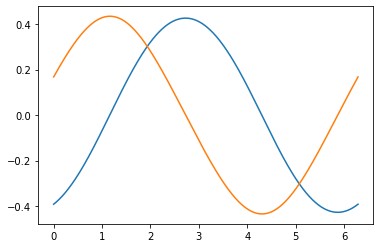

In [83]:
error(sol, plot=1, alpha=1)

## Вывод результата в файл

In [84]:
ans = ""
sol = solve(nonnanvals1[2])[1]
for i in sol:
    ans += '%.16f'%i[0] + "\t\t" + '%.16f'%(i[1]) + "\n"
    
with open("./output_1.txt", "w") as file:
    file.write(ans)

# Повторение программы при $\alpha=2$

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

[[-0.6  0.9]
 [-0.6  1. ]
 [-0.5  0.6]
 [-0.5  0.7]
 [-0.5  0.8]
 [-0.4  0.4]
 [-0.4  0.5]
 [-0.4  0.6]
 [-0.4  0.7]
 [-0.3  0.2]
 [-0.3  0.3]
 [-0.3  0.4]
 [-0.3  0.5]
 [-0.2  0. ]
 [-0.2  0.1]
 [-0.2  0.2]
 [-0.2  0.3]
 [-0.1 -0.3]
 [-0.1 -0.2]
 [-0.1 -0.1]
 [-0.1  0. ]
 [ 0.  -0.5]
 [ 0.  -0.4]
 [ 0.  -0.3]
 [ 0.  -0.2]
 [ 0.1 -0.7]
 [ 0.1 -0.6]
 [ 0.1 -0.5]
 [ 0.1 -0.4]
 [ 0.2 -0.9]
 [ 0.2 -0.8]
 [ 0.2 -0.7]
 [ 0.3 -1. ]
 [ 0.3 -0.9]]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[-0.26128685  0.23509226]


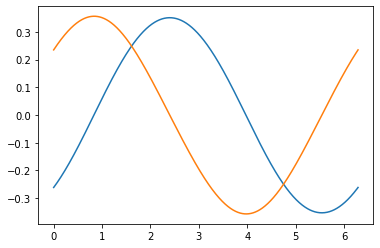

In [88]:
nonnanvals2, errors2 = Shooting(iters=0, alpha=2)
print(nonnanvals2)

for p in nonnanvals1:
    sol = newtonian_finder(p, silent=1, alpha=2)
    if  not any(np.isnan(sol)):
        print(sol)
        break

error(sol, plot=1, alpha=2)
        
ans = ""
data = solve(sol, alpha=2)[1]
for i in data:
    ans += '%.16f'%i[0] + "\t\t" + '%.16f'%(i[1]) + "\n"
    
with open("./output_2.txt", "w") as file:
    file.write(ans)

# Остатки кода с градиентным спуском

Далее, пробежимся по найденым точкам и попробуем "добить" найденные точки градиентным спуском(SGD с Нестеровым), среди найденных выберем лучшее. Очевидно, здесь мы просто надеемся, что реальное приодическое решение попало в окрестность одной из настрелянных точек, в которой решение диффура гладко зависит от начальных параметров. Где нет - спуск по градиенты быстро выкидывает за область допустимых начальных значений.

Здесь мы полагаемся еще и на то что первые несколько шагов градиентного спуска сделают большую часть приближения. Нестеров был приписан только с надеждой далее лучшую из выбранных точек приблизить достаточно хорошо.

In [10]:
'''
def ev_grad(y, d = 0.0001):
    dx = np.array([d, 0])
    dy = np.array([0, d])
    
    erd = ((np.array([error(y+dx), error(y+dy)]) - error(y))/d)
    #print(erd)
    return erd
    
def grad_desc(y0, rate=0.00001, maxstep=100, callback=1, nester = 0.1):
    step=0
    y = y0
    bestval = error(y0)
    beststep = 0
    beststepcombo = 0
    gr = np.array([0, 0])
    
    while(step < maxstep and not any(np.isnan(y))):
        
        gr = nester*gr + (1-nester)*ev_grad(y, d=rate)
        y = y - rate*gr
        val = error(y)
        
        if (val < bestval):
            bestval = val
            beststep = step
            beststepcombo += 1
        else:
            beststepcombo = 0
        if (step - beststep > 5):
            rate=rate/10
            beststep = step
            print(f"New lr rate is {rate}")
        if (beststepcombo > 50):
            rate=rate*2
            beststepcombo = 0
            print(f"New lr rate is {rate}")    
        if (rate < 1e-10):
            break
        if step%callback==0:
            print(f"step {step}:", gr, y, error(y))
        step+=1
    return y

def vals_optim(nonnanvals, maxstep=10, callback=5, plot=0):
    nonnanvals_opimized = []
    for bp in tqdm(nonnanvals):
        print(f"\n\nOptimizing point {bp}")
        ans = grad_desc(bp, rate=0.00001, maxstep=maxstep, callback=callback)
        if not any(np.isnan(ans)):
            nonnanvals_opimized.append([ans, error(ans, plot=plot)])
        plt.show()
    return nonnanvals_opimized
'''

In [ ]:
'''nonnanvals_opimized1 = vals_optim(nonnanvals1)

[array([-0.4080975 ,  0.19510771]), 0.003357392405906784]


0.003357392405906784

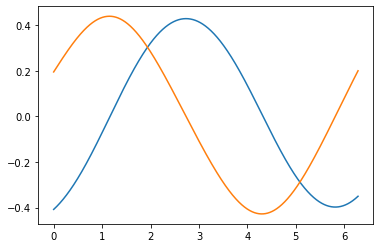

In [12]:
'''minid1 = np.array(nonnanvals_opimized1, dtype=object).T[1].argmin()
print(nonnanvals_opimized1[minid1])
error(nonnanvals_opimized1[minid1][0], plot=1)